<a href="https://colab.research.google.com/github/BennoKrojer/ML2/blob/main/Project2_Part1%2B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 551 - Mini Project 2


# Part 1


In [ ]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/diabetes_data/diabetes_train.csv
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/diabetes_data/diabetes_test.csv
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/diabetes_data/diabetes_val.csv

In [ ]:
train = genfromtxt('diabetes_train.csv', delimiter=',', skip_header=1)
test = genfromtxt('diabetes_test.csv', delimiter=',', skip_header=1)
val = genfromtxt('diabetes_val.csv', delimiter=',', skip_header=1)
train_x, train_y = train[:,:-1], train[:,-1]
test_x, test_y = test[:,:-1], test[:,-1]
val_x, val_y = val[:,:-1], val[:,-1]
print(train_x.shape)

(600, 8)


## Logistic Regression: Fully Batched

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

In [ ]:
class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, eval_steps=100):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # to get the tolerance for the norm of gradients
        self.max_iters = max_iters  # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.eval_steps = eval_steps

    def fit(self, x, y, val_x, val_y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        steps = []
        train_accs = []
        val_accs = []
        best_val_acc = 0
        best_step = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            t += 1
            if t % self.eval_steps == 0:
                yh = self.predict(x)
                yh = yh > 0.5
                preds = y == yh
                train_acc = sum(preds) / len(preds)

                val_yh = self.predict(val_x, add_bias=True)
                val_yh = val_yh > 0.5
                val_preds = val_y == val_yh
                val_acc = sum(val_preds) / len(val_preds)

                steps.append(t)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_step = t

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, steps, train_accs, val_accs, best_val_acc, best_step

    def predict(self, x, add_bias=False):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = logistic(np.dot(x, self.w))  # predict output
        return yh



LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

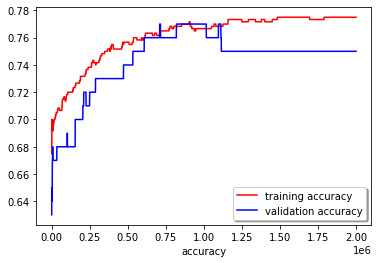

0.0002
0.77
709300


In [ ]:
for lr in [0.0004, 0.0002, 0.0001, 0.00005]:
    logres = LogisticRegression(max_iters=2e6, learning_rate=lr)
    model, steps, train_accs, val_accs, best_val_acc, best_step = logres.fit(train_x, train_y, val_x, val_y)
    plt.plot(steps, train_accs, 'r', label='training accuracy')
    plt.plot(steps, val_accs, 'b', label='validation accuracy')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.show()
    print(lr)
    print(best_val_acc)
    print(best_step)

## Mini-Batch Logistic Regression

In [ ]:
class MiniBatchLogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, batch_size=8, max_iters=1e5, verbose=False,
                 eval_steps=100, shuffle=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # to get the tolerance for the norm of gradients
        self.max_iters = max_iters  # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.eval_steps = eval_steps
        self.batch_size = batch_size
        self.shuffle = shuffle

    def fit(self, x, y, val_x, val_y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        steps = []
        train_accs = []
        val_accs = []
        best_val_acc = 0
        best_step = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            if self.shuffle:
                p = np.random.permutation(int(y.shape[0]))
                x = x[p]
                y = y[p]
            for i in range(0, int(y.shape[0]), self.batch_size):
                batch_x = x[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                g = self.gradient(batch_x, batch_y)
                self.w = self.w - self.learning_rate * g
            t += 1
            if t % self.eval_steps == 0:
                print(t)
                yh = self.predict(x)
                yh = yh > 0.5
                preds = y == yh
                train_acc = sum(preds) / len(preds)

                val_yh = self.predict(val_x, add_bias=True)
                val_yh = val_yh > 0.5
                val_preds = val_y == val_yh
                val_acc = sum(val_preds) / len(val_preds)

                steps.append(t)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_step = t

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, steps, train_accs, val_accs, best_val_acc, best_step

    def predict(self, x, add_bias=False):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = logistic(np.dot(x, self.w))  # predict output
        return yh


In [ ]:
MiniBatchLogisticRegression.gradient = gradient  # initialize the gradient method of the LogisticRegression class with gradient function

taccs = {}
vaccs = {}
for size in [8, 16, 32, 64, 600]:
    logres = MiniBatchLogisticRegression(max_iters=1e6, learning_rate=0.0002, batch_size=size)
    model, steps, train_accs, val_accs, best_val_acc, best_step = logres.fit(train_x, train_y, val_x, val_y)
    taccs[size] = train_accs
    vaccs[size] = val_accs

plt.xlabel('iterations')
plt.ylabel('accuracy')
for size, vals in taccs.items():
    plt.plot(steps, vals, label=f'batch size {size}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.show()

plt.xlabel('iterations')
plt.ylabel('accuracy')
for size, vals in vaccs.items():
    plt.plot(steps, vals, label=f'batch size {size}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.show()


In [ ]:
# PURPOSE: test whether it makes no difference if we don't shuffle and plot averaged accuracies
MiniBatchLogisticRegression.gradient = gradient  # initialize the gradient method of the LogisticRegression class with gradient function

taccs = {}
vaccs = {}
for size in [8, 16, 32, 64, 600]:
    logres = MiniBatchLogisticRegression(max_iters=1e4, learning_rate=0.0002, batch_size=size, shuffle=True)
    model, steps, train_accs, val_accs, best_val_acc, best_step = logres.fit(train_x, train_y, val_x, val_y)
    taccs[size] = train_accs
    vaccs[size] = val_accs

plt.xlabel('iterations')
plt.ylabel('accuracy')
for size, vals in taccs.items():
    new_vals = []
    for i,v in enumerate(vals):
        if i < 3:
            new_vals.append(v)
        else:
            new_vals.append(np.mean(vals[i-3:i+1]))
    plt.plot(steps, vals, label=f'batch size {size}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.savefig('bestfigevert_shuffled.png')

plt.clf()

plt.xlabel('iterations')
plt.ylabel('accuracy')
for size, vals in vaccs.items():
    new_vals = []
    for i,v in enumerate(vals):
        if i < 3:
            new_vals.append(v)
        else:
            new_vals.append(np.mean(vals[i-3:i+1]))
    plt.plot(steps, vals, label=f'batch size {size}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.savefig('bestfigeverv_shuffled.png')

## Momentum Fully Batched Gradient Descent

In [ ]:
def gradient(self, x, y):
    N, D = x.shape
    yh = logistic(np.dot(x, self.w))  # predictions  size N
    grad = np.dot(x.T, yh - y) / N  # divide by N because cost is mean over N points
    J = np.mean(-y * np.log(yh) - (1-y) * np.log(1-yh))
    return grad, J  # size D

In [ ]:
class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, eval_steps=100, momentum_beta=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # to get the tolerance for the norm of gradients
        self.max_iters = max_iters  # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.eval_steps = eval_steps
        self.momentum_beta = momentum_beta

    def fit(self, x, y, val_x, val_y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        steps = []
        train_accs = []
        val_accs = []
        losses = []
        best_val_acc = 0
        best_step = 0
        prev = np.zeros(D)
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g, loss = self.gradient(x, y)
            g = self.momentum_beta * prev + (1-self.momentum_beta) * g
            prev = g
            self.w = self.w - self.learning_rate * g
            t += 1
            if t % self.eval_steps == 0:
                yh = self.predict(x)
                yh = yh > 0.5
                preds = y == yh
                train_acc = sum(preds) / len(preds)

                val_yh = self.predict(val_x, add_bias=True)
                val_yh = val_yh > 0.5
                val_preds = val_y == val_yh
                val_acc = sum(val_preds) / len(val_preds)

                steps.append(t)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                losses.append(loss)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_step = t

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, steps, train_accs, val_accs, best_val_acc, best_step, losses

    def predict(self, x, add_bias=False):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = logistic(np.dot(x, self.w))  # predict output
        return yh

In [ ]:
LogisticRegression.gradient = gradient # initialize the gradient method of the LogisticRegression class with gradient function

taccs = {}
vaccs = {}
losses = {}
for beta in [0.8, 0.9, 0.95, 0.99, 0]:
    logres = LogisticRegression(max_iters=2e3, learning_rate=0.0002, momentum_beta=beta)
    model, steps, train_accs, val_accs, best_val_acc, best_step, loss = logres.fit(train_x, train_y, val_x, val_y)
    taccs[beta] = train_accs
    vaccs[beta] = val_accs
    losses[beta] = loss

plt.xlabel('iterations')
plt.ylabel('accuracy')
for beta, vals in taccs.items():
    plt.plot(steps, vals, label=f'momentum coefficient {beta}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plot.show()

plt.xlabel('iterations')
plt.ylabel('accuracy')
for beta, vals in vaccs.items():
    plt.plot(steps, vals, label=f'momentum coefficient {beta}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plot.show()

plt.xlabel('iterations')
plt.ylabel('cross-entropy loss')
for beta, vals in losses.items():
    plt.plot(steps, vals, label=f'momentum coefficient {beta}')
    plt.legend(loc='upper right', shadow=True, fontsize='medium')
    plt.show()

## Momemtum with Mini-Batch SGD

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

In [ ]:
class MiniBatchLogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, batch_size=8, max_iters=1e5, verbose=False,
                 eval_steps=100, shuffle=False, momentum_beta=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # to get the tolerance for the norm of gradients
        self.max_iters = max_iters  # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.eval_steps = eval_steps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.momentum_beta = momentum_beta

    def fit(self, x, y, val_x, val_y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        steps = []
        train_accs = []
        val_accs = []
        best_val_acc = 0
        best_step = 0
        prev = np.zeros(D)
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            if self.shuffle:
                p = np.random.permutation(int(y.shape[0]))
                x = x[p]
                y = y[p]
            if self.batch_size != 600:
                for i in range(0, int(y.shape[0]), self.batch_size):
                    batch_x = x[i:i+self.batch_size]
                    batch_y = y[i:i+self.batch_size]
                    g = self.gradient(batch_x, batch_y)
                    g = self.momentum_beta * prev + (1 - self.momentum_beta) * g
                    self.w = self.w - self.learning_rate * g
                    prev = g
            else:
                g = self.gradient(x, y)
                self.w = self.w - self.learning_rate * g
                prev = g
            t += 1
            if t % self.eval_steps == 0:
                print(t)
                yh = self.predict(x)
                yh = yh > 0.5
                preds = y == yh
                train_acc = sum(preds) / len(preds)

                val_yh = self.predict(val_x, add_bias=True)
                val_yh = val_yh > 0.5
                val_preds = val_y == val_yh
                val_acc = sum(val_preds) / len(val_preds)

                steps.append(t)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_step = t

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, steps, train_accs, val_accs, best_val_acc, best_step

    def predict(self, x, add_bias=False):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = logistic(np.dot(x, self.w))  # predict output
        return yh

In [ ]:
MiniBatchLogisticRegression.gradient = gradient  # initialize the gradient method of the LogisticRegression class with gradient function

for bs in [8, 64]:
    taccs = {}
    vaccs = {}
    for beta in [0.8, 0.9, 0.95, 0.99, 0]:
        logres = MiniBatchLogisticRegression(max_iters=1e6, learning_rate=0.0002, momentum_beta=beta, batch_size=bs)
        model, steps, train_accs, val_accs, best_val_acc, best_step = logres.fit(train_x, train_y, val_x, val_y)
        taccs[beta] = train_accs
        vaccs[beta] = val_accs

    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    for beta, vals in taccs.items():
        plt.plot(steps, vals, label=f'momentum coefficient {beta}')
        plt.legend(loc='lower right', shadow=True, fontsize='medium')
        plt.show()

    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    for beta, vals in vaccs.items():
        plt.plot(steps, vals, label=f'momentum coefficient {beta}')
        plt.legend(loc='lower right', shadow=True, fontsize='medium')
        plt.show()

# Part 2

In [1]:
from collections import Counter
from math import log
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
# LemmaTokenizer defintion
class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

### Data Loading

In [4]:
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_train.csv
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_val.csv
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_test.csv

--2021-10-26 19:43:44--  https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63830815 (61M) [text/plain]
Saving to: ‘fake_news_train.csv’

fake_news_train.csv 100%[===================>]  60.87M   159MB/s    in 0.4s    

2021-10-26 19:43:45 (159 MB/s) - ‘fake_news_train.csv’ saved [63830815/63830815]

--2021-10-26 19:43:45--  https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_val.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 20

In [5]:
!ls

fake_news_test.csv  fake_news_train.csv  fake_news_val.csv  sample_data


In [6]:
raw_data_train = pd.read_csv("fake_news_train.csv")
raw_data_val   = pd.read_csv("fake_news_val.csv")
raw_data_test  = pd.read_csv("fake_news_test.csv")

raw_data_train.head
raw_data_train.columns

Index(['text', 'label'], dtype='object')

In [7]:
# Seperate raw data into text and label
raw_data_train_text = raw_data_train["text"]
raw_data_train_label = raw_data_train["label"]

# Convert to numpy array so it is easier to work with
X_train = np.asarray(raw_data_train_text)

# Create numpy array to store target labels
Y_train = np.asarray(raw_data_train_label)
Y_train

print(X_train.shape)
print(Y_train.shape)

(20000,)
(20000,)


In [8]:
# Seperate raw data for validation set
raw_data_val_text = raw_data_val["text"]
raw_data_val_label = raw_data_val["label"]
X_val = np.asarray(raw_data_val_text)
Y_val = np.asarray(raw_data_val_label)
Y_val
print(X_val.shape)
print(Y_val.shape)

(2000,)
(2000,)


In [9]:
# Seperate raw data for test set
raw_data_test_text = raw_data_test["text"]
raw_data_test_label = raw_data_test["label"]
X_test = np.asarray(raw_data_test_text)
Y_test = np.asarray(raw_data_test_label)
print(X_test.shape)
print(Y_test.shape)

(3000,)
(3000,)


### Data Pre-Processing
To preform machine learning on text, need to first extract features for the text.

#### Bag of Words (Vectorizing)
For the bag of words method, each word in the training data set is given an integer ID, then for each data sample, count the number of occurrences of each word, and store the count of each word as a feature for the training sample.  

Ex:  
`Data sample 'i' = "The quick brown fox jumped over the brown dog"`  
`if id for word "brown" = 3`  
`store X[i, 3] = 2 (word count)`    

This method implies that the number of features = number of unique words in all training samples. Number features is typically > 100,000.  

Thus, if every sample had every word, then the size of the matrix would be 100,000 x 100,000 x 4 bytes, which is not very practical. Luckily, most features will be zero for most samples, as most features only contain a small subset of the total set of words in the data set. For this reason, we usually say that the bag of words features array are *high-dimensional sparse data sets*.  

Will use scipy.sparse matrix to store data set features




In [10]:
# Use sklearn.feature_extraction.text.CountVectorizer
# To build a dictionary of features, and transform data samples into feature vectors
count_vect = CountVectorizer()

# training feature vectors
X_train_counts = count_vect.fit_transform(raw_data_train_text)
X_train_counts.shape

(20000, 145402)

#### Occurences -> Frequencies (Transforming)
Occurence count is a good start, but is skewed towards longer documents. Longer text will on average have more occurences than shorter text. To compensate for this, we can look at term frequencies which is the number of occurences of a word in some text, divided by the total number of words in that text.  

#### Downscale Word Weights
Another pre-processing technique for text is to give higher weights to rarer words, and lower weights to words that appear frequently in the overall set of text. This is down by downscaling the weights of words that appear frequently in all texts.  

These two approaches can be combined into something called tf-idf, or Term Frequency times Inverse Document Frequency. Can be computed using sklearn->TfidfTransformer.

In [11]:
tfidf_transformer = TfidfTransformer()
# fit_transform combines fit and transform into one step
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(20000, 145402)

#### Scaling Features / Reducing \# Features


# terms:  (20000, 145094)


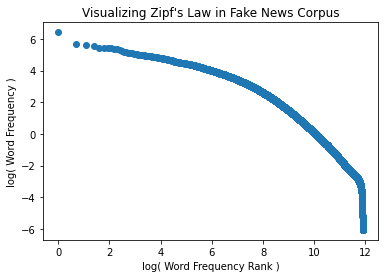

In [18]:
# Remove default stop words
cv = CountVectorizer(stop_words='english')
X_train_counts = cv.fit_transform(X_train)
print("# terms: ", X_train_counts.shape)
tfidf_transformer = TfidfTransformer()
X_train_freq = tfidf_transformer.fit_transform(X_train_counts)

# Create dictionary of corpus freq and plot
word_list = cv.get_feature_names()
freq_list = np.asarray(X_train_freq.sum(axis=0))[0]
freq_dict = dict(zip(word_list, freq_list))
plot_zipf(freq_dict)

# terms:  (20000, 70631)


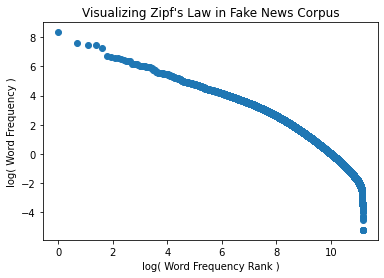

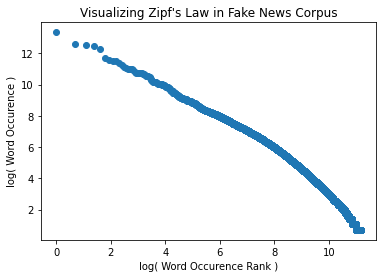

In [19]:
# Remove all words with only 1 occurence
cv = CountVectorizer(min_df=2)
X_train_counts = cv.fit_transform(X_train)
print("# terms: ", X_train_counts.shape)
tfidf_transformer = TfidfTransformer()
X_train_freq = tfidf_transformer.fit_transform(X_train_counts)

# Create dictionary of corpus freq and plot
word_list = cv.get_feature_names()
freq_list = np.asarray(X_train_freq.sum(axis=0))[0]
freq_dict = dict(zip(word_list, freq_list))
plot_zipf(freq_dict)

# Also plot corpus zipf with count instead of frequency
count_list = np.asarray(X_train_counts.sum(axis=0))[0]
count_dict = dict(zip(word_list, count_list))
plot_zipf(count_dict, ylabel="log( Word Occurence )", xlabel="log( Word Occurence Rank )")

# terms:  (20000, 145379)
stop words for max_df= 0.7 : 
{'from', 'has', 'this', 'it', 'in', 'the', 'have', 'was', 'but', 'for', 'an', 'that', 'be', 'is', 'by', 'of', 'and', 'as', 'to', 'at', 'on', 'with', 'are'}


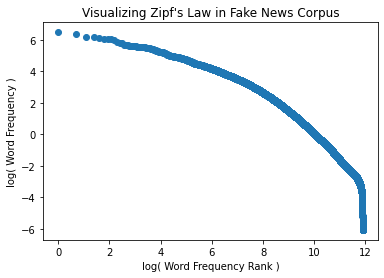

In [20]:
# Remove words that appear too frequently
max_df_test = 0.7
cv = CountVectorizer(max_df=max_df_test)
X_train_counts = cv.fit_transform(X_train)
print("# terms: ", X_train_counts.shape)
print("stop words for max_df=", max_df_test,": ")
print(cv.stop_words_)
tfidf_transformer = TfidfTransformer()
X_train_freq = tfidf_transformer.fit_transform(X_train_counts)

# Create dictionary of corpus freq and plot
word_list = cv.get_feature_names()
freq_list = np.asarray(X_train_freq.sum(axis=0))[0]
freq_dict = dict(zip(word_list, freq_list))
plot_zipf(freq_dict)

#### Feature Visualization - Zipf's Law 

Zipf's law: plot of log(rank) vs log(freq) should be approx. straight line with slope = -1  
x = log(index)  
y = log(freq)  

In [13]:
# Start with dictionary: {(word: freq), ...}
# Should work with frequency or count
def plot_zipf(word_dict, xlabel=None, ylabel=None, save=None):
  # Sort dictionary
  counter = Counter(word_dict)
  word_dict = counter.most_common()
  logIndexs = list()
  logCounts = list()
  i = 1 # log(0) is undefined, so start rank at 1
  for word in word_dict:
    logIndexs.append(log(i))
    word_freq = word[1]
    logCounts.append(log(word_freq))
    i += 1
  # plot using matplotlib scatter
  fig, ax = plt.subplots() # figsize=(10, 6)
  ax.scatter(logIndexs, logCounts)
  if xlabel == None:
    xlabel = "log( Word Frequency Rank )"
  ax.set_xlabel(xlabel)
  if ylabel == None:
    ylabel = "log( Word Frequency )"
  ax.set_ylabel(ylabel)
  ax.set_title("Visualizing Zipf's Law in Fake News Corpus")
  if save is not None:
    fig.savefig(save)


In [14]:
cv = CountVectorizer()
X_counts_test = cv.fit_transform(X_train)

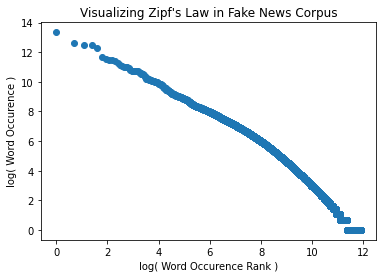

In [15]:
occurence_list = np.asarray(X_counts_test.sum(axis=0))[0]
#print(list(occurence_list[0]))
word_list = cv.get_feature_names()
test_dict = dict(zip(word_list, occurence_list))

plot_zipf(test_dict, ylabel="log( Word Occurence )", xlabel="log( Word Occurence Rank )", save="zipf_occur.png")

In [16]:
# Zipf's Law with freq instead of occurence
# First get frequencies from count using tfidf_transformer
tfidf_transformer = TfidfTransformer()
X_tfidf_test = tfidf_transformer.fit_transform(X_counts_test)

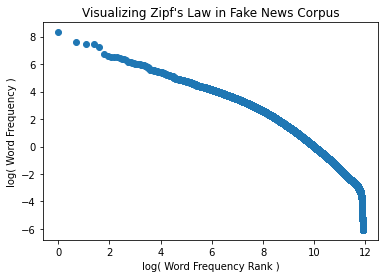

In [17]:
freq_list = np.asarray(X_tfidf_test.sum(axis=0))[0]
#print(freq_list)
freq_dict = dict(zip(word_list, freq_list))

plot_zipf(freq_dict, save="zipf_freq.png")

### Model Training
Linear model - Logistic Regression using sklearn.linear_model.LogisticRegression  

Start with default parameters for Logistic Regression classifier:  
- penalty  - norm of the penalty (default = 'l2')  
- tol      - tolerance for stopping criteria (default = 1e-4)  
- max_iter - Maximum number of iterations taken for the solvers to converge (default = 100) 

can also specify # cpus to use
n_jobs = default = None: means 1, use -1 to specify all processors

#### Fit

In [25]:

# clf = classifier
clf = LogisticRegression(penalty='l2', tol=1e-4, max_iter=1000, solver='saga')

# fit classifier
clf = clf.fit(X_train_tfidf, Y_train)



In [34]:
# First need to apply same preprocessing to test dataset

# also refit cv and tfidf transformers in case they have be modified
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Score
Y_score = clf.decision_function(X_test_tfidf)
Y_score

array([ 0.52447739, -0.06038792,  0.97423826, ..., -0.46022243,
        0.72943693,  0.31363839])

#### Validate

In [35]:
# Pre process validation data in same way as train data
# But only transform data, as count_vectorizer and tfidf_transformer have already been
# fit to training data (and don't want to fit to validation or test data)

X_val_counts = count_vect.transform(raw_data_val_text)
print("X_val_counts.shape: ", X_val_counts.shape)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)
print("X_val_tfidf.shape: ", X_val_tfidf.shape)

val_pred = clf.predict(X_val_tfidf)

print("val_pred.shape: ", val_pred.shape)
print("Y_val.shape: ", Y_val.shape)

# Compare predicitions to labels
np.mean(val_pred == Y_val)

X_val_counts.shape:  (2000, 145402)
X_val_tfidf.shape:  (2000, 145402)
val_pred.shape:  (2000,)
Y_val.shape:  (2000,)


0.731

### Pipeline (Data Pre-Processing + Model Training)
In order to make our sequence of pre-processing and classifying easier, sklearn allows us to create a pipeline to apply the operations to a set of data: vectorizer->transformer->classifier.  
- Vectorizer ("vect") = Bag of Words, transform text to counts of words in text
- Transformer ("tfidf") = TF-IDF transform
- Classifier ("lr-clf") = Logistic Regression classifier

In [36]:
text_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("lr-clf", LogisticRegression(max_iter=500, solver='saga')),
])

In [ ]:
# Can now train using a single command / function
text_pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('lr-clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,

In [ ]:
# Train pipeline using train set
text_pipeline.score(raw_data_train_text, Y_train)

0.85525

In [ ]:
# Predict labels for train set using pipeline
Y_pred = text_pipeline.predict(raw_data_train_text)
#print("Y_pred.shape: ", Y_pred.shape, ", Y_train.shape: ", Y_train.shape)
acc = np.mean(Y_pred == Y_train)
print(acc)

0.85525


In [ ]:
# Validate using pipeline
Y_pred = text_pipeline.predict(raw_data_val_text)
#print("Y_pred.shape: ", Y_pred.shape, ", Y_val.shape: ", Y_val.shape)
acc = np.mean(Y_pred == Y_val)
print(acc)

0.731


### Parameter Tuning

First using grid search and then random search or other methods..

tol: float, default=1e-4
Tolerance for stopping criteria.

C: float, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

#### Grid Search

In [ ]:
parameters = {
    'vect__ngram_range': [(1,1), (1,2)],
    'tfidf__use_idf': (True, False),
    'lr-clf__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'lr-clf__tol': [1e-4, 1e-3, 1e-2], # tolerance for gradient decsent stopping criteria
    'lr-clf__C': [1,2], # regularization parameter
    'lr-clf__random_state': [None, 1], # shuffled vs unshuffled
    'lr-clf__max_iter': [100, 500, 1000, 5000]
}
parameters = {
    'vect__ngram_range': [(1,1), (1,2)]
}
print(text_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'lr-clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'lr-clf__C', 'lr-clf__class_weight', 'lr-clf__dual', 'lr-clf__fit_intercept', 'lr-clf__intercept_scaling', 'lr-clf__l1_ratio', 'lr-clf__max_iter', 'lr-clf__multi_class', 'lr-clf__n_jobs', 'lr-clf__penalty', 'lr-clf__random_state', 'lr-clf__solver', 'lr-clf__tol', 'lr-clf__verbose', 'lr-clf__warm_start'])


In [ ]:
gs_clf = GridSearchCV(text_pipeline, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, Y_train)
gs_clf.predict(X_test)
gs_clf.best_score_
gs_clf.best_params_

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.71415

Parameter tuning, but focusing on parameters for preprocessing rather than classifying

In [ ]:
tuning_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=LemmaTokenizer())),
    ("tfidf", TfidfTransformer()),
    ("lr-clf", LogisticRegression(max_iter=500, random_state=0)),
])

In [38]:
parameters = {
    #'vect__max_df': [1.0, 0.6, 0.7, 0.8], # default = 1.0
    'vect__max_features': [10000, 50000, None], # default = None
    'vect__min_df': [1, 2, 3], # default = 1
    'vect__ngram_range': [(1,1), (1,2), (2,2)], # default = (1,1)
    #'vect__stop_words': [None, 'english'], # default = None
    #'vect__strip_accents': [None, 'ascii'], # default = None
    #'vect__tokenizer': [None, LemmaTokenizer()], # default = None
    'tfidf__use_idf': (True, False), # default = True
    #'lr-clf__random_state': [None, 1], # shuffled vs unshuffled
}
print(parameters)

{'vect__max_features': [10000, 50000, None], 'vect__min_df': [1, 2, 3], 'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'tfidf__use_idf': (True, False)}


In [ ]:
# Reduce training dataset size to speedup parameter searching
param_train_X = X_train[:1000]
param_train_Y = Y_train[:1000]
param_training = list(zip(param_train_X, param_train_Y))
#print(param_training[0])
# shuffle list
random.seed(0)
random.shuffle(param_training)
param_train_X = list()
param_train_Y = list()
for data in param_training:
  param_train_X.append(data[0])
  param_train_Y.append(data[1])
#print(param_train_X[0])
#print(param_train_Y[0])

In [ ]:

param_search = GridSearchCV(text_pipeline, parameters, cv=5, n_jobs=-1)
param_search = param_search.fit(param_train_X, param_train_Y)
#param_search.predict(X_test)
print(param_search.best_score_)
print(param_search.best_params_)

0.617
{'tfidf__use_idf': False, 'vect__max_features': 10000, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}


```{'tfidf__use_idf': False, 'vect__max_features': 10000, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}``` on full dataset gave acc: 0.699

```{'tfidf__use_idf': False, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}``` on full dataset gave acc: 0.699

```{'tfidf__use_idf': True, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}``` on full dataset gave acc: 0.697666

In [23]:
best_param_pipeline = Pipeline([
    ("vect", CountVectorizer(max_features=None,min_df=1,ngram_range=(1,2))),
    ("tfidf", TfidfTransformer(use_idf=True)),
    ("lr-clf", LogisticRegression(max_iter=500, solver='saga')),
])
fitted_param_pipeline = best_param_pipeline.fit(X_train, Y_train)
Y_pred = best_param_pipeline.predict(X_test)
Y_param_score = fitted_param_pipeline.decision_function(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.697


#### Random Search 

with All Params

In [ ]:
param_search = RandomizedSearchCV(text_pipeline, parameters, cv=5, n_jobs=-1)
param_search = param_search.fit(X_train, Y_train)
#param_search.predict(X_test)
print(param_search.best_score_)
print(param_search.best_params_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


#### Individual Parameter Tuning

Searching all parameters at once (Grid or Random search) is really slow, so first try tuning just one parameter at a time.

Max_Df parameter tuning


In [ ]:
parameters = {'vect__max_df': [1.0, 0.6, 0.7, 0.8]}
param_search = GridSearchCV(text_pipeline, parameters, cv=5, n_jobs=-1)
param_search = param_search.fit(X_train, Y_train)
param_search.predict(X_test)
print(param_search.best_score_)
print(param_search.best_params_)

0.71415
{'vect__max_df': 1.0}


In [ ]:
test_mindf_pipeline = Pipeline([
    ("vect", CountVectorizer(max_df=0.7)),
    ("tfidf", TfidfTransformer()),
    ("lr-clf", LogisticRegression(max_iter=5000)),
])
test_mindf_pipeline.fit(X_train, Y_train)
Y_pred = test_mindf_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.709


min_df parameter tuning

In [ ]:
test_mindf_pipeline = Pipeline([
    ("vect", CountVectorizer(min_df=2)),
    ("tfidf", TfidfTransformer()),
    ("lr-clf", LogisticRegression(max_iter=5000)),
])
test_mindf_pipeline.fit(X_train, Y_train)
Y_pred = test_mindf_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.713


Stop word tuning

In [ ]:
test_stopword_pipeline = Pipeline([
    ("vect", CountVectorizer(stop_words='english')),
    ("tfidf", TfidfTransformer()),
    ("lr-clf", LogisticRegression()),
])
test_stopword_pipeline.fit(X_train, Y_train)
print("num features: ", len(test_stopword_pipeline['vect'].get_feature_names()))
Y_pred = test_stopword_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

num features:  145094
0.6856666666666666


IDF vs No-IDF tuning

In [ ]:
test_noidf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer(use_idf=False)),
    ("lr-clf", LogisticRegression()),
])
test_noidf_pipeline.fit(X_train, Y_train)
Y_pred = test_noidf_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6833333333333333


n-grams parameter tuning  

Big help!!!  
ngram_range=(1,2) results in acc = 0.76633....  (with max_iter = 5000)   
ngram_range=(1,2) results in acc = 0.76466....  (with max_iter = 500) 

ngram_range=(2,2) results in acc = 

In [ ]:
test_ngrams_pipeline = Pipeline([
    ("vect", CountVectorizer(max_features=10000,ngram_range=(1, 2))),
    ("tfidf", TfidfTransformer()),
    ("lr-clf", LogisticRegression(max_iter=5000, solver='saga')),
])
test_ngrams_pipeline.fit(X_train, Y_train)
Y_pred = test_ngrams_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.7256666666666667


Lemmatizer tuning  
Gained 1% accuray using lemmatizer!!

In [ ]:
test_mindf_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer = LemmaTokenizer(), min_df=2)),
    ("tfidf", TfidfTransformer()),
    ("lr-clf", LogisticRegression(max_iter=5000, solver='saga')),
])
fitted_lemma_pipeline = test_mindf_pipeline.fit(X_train, Y_train)
Y_pred = test_mindf_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.72


In [ ]:
Y_score_lemma = fitted_lemma_pipeline.decision_function(X_test)

Classifier Tuning

SGD classifier gives way lower accuracy: 0.59 (SGD) vs 0.71 (Lin Reg)

In [ ]:
test_svm_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer = LemmaTokenizer(), min_df=2)),
    ("tfidf", TfidfTransformer()),
    ("svm-clf", SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-3, random_state=42,
                              max_iter=500, tol=None)),
])
fitted_svm_pipeline = test_svm_pipeline.fit(X_train, Y_train)
Y_score_svm = fitted_svm_pipeline.decision_function(X_test)
Y_pred = test_svm_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.59


In [ ]:
test_tree_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer = LemmaTokenizer(), min_df=2)),
    ("tfidf", TfidfTransformer()),
    ("tree-clf", RandomForestClassifier(max_depth=2, random_state=0)),
])
fitted_tree_pipeline = test_tree_pipeline.fit(X_train, Y_train)
#Y_score_tree = fitted_tree_pipeline.decision_function(X_test)
Y_pred = test_tree_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.59


### Model Evalutation (testing)
Now test performance of model using testing data

#### Test accuracy

In [ ]:
# Test model acc with test data
Y_pred = text_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.71


In [ ]:
# Get score
#print(X_train.ravel().shape)
#print(Y_train.shape)
#print(Y_test.shape)
fitted_pipeline = text_pipeline.fit(X_train.ravel(), Y_train)
#print(len(Y_train.tolist()))
Y_score = fitted_pipeline.decision_function(X_test)
Y_score.shape

(3000,)

In [ ]:
X_test.shape

(3000,)

#### Model Metrics

Confusion matrix  
ROC curve


In [ ]:
# Confusion matrix for binary classification: 
conf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
conf_matrix

array([[ 554,  676],
       [ 194, 1576]])

##### ROC curve for default pipeline

In [ ]:
# Compute ROC curve and ROC area
fprs = list()
tprs = list()
fprs, tprs, thresholds = roc_curve(Y_test, Y_score)
roc_auc = auc(fprs, tprs)

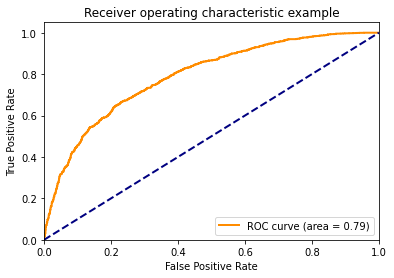

In [ ]:
#Plot ROC Curve
plt.figure()
lw = 2
plt.plot(fprs, tprs, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic no parameter tuning')
plt.legend(loc="lower right")
plt.show()

##### ROC curve for best fit from param search


In [ ]:
best_params_pipeline = Pipeline([
    ("vect", CountVectorizer(ngram_range=(1, 2))),
    ("tfidf", TfidfTransformer(use_idf=True)),
    ("lr-clf", LogisticRegression(max_iter=1000)),
])
fitted_best_params_pipeline = best_params_pipeline.fit(X_train, Y_train)
Y_score_best_params = fitted_best_params_pipeline.decision_function(X_test)
Y_pred = best_params_pipeline.predict(X_test)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.6976666666666667


In [ ]:
# Compute ROC curve and ROC area
fprs = list()
tprs = list()
fprs, tprs, thresholds = roc_curve(Y_test, Y_score_best_params)
roc_auc = auc(fprs, tprs)

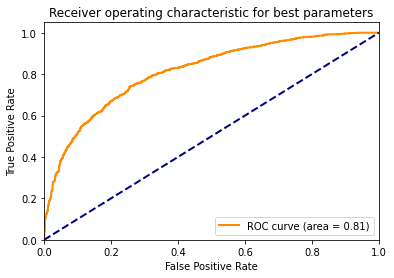

In [ ]:
#Plot ROC Curve
plt.figure()
lw = 2
plt.plot(fprs, tprs, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for best parameters')
plt.legend(loc="lower right")
plt.show()